<a href="https://colab.research.google.com/github/kaustavm22/Transfer-Learning-102-Flowers-/blob/main/Flower_102_transfer_learning_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!pip install keras

In [3]:
!kaggle datasets download -d demonplus/flower-dataset-102

100% 329M/329M [00:02<00:00, 139MB/s]
100% 329M/329M [00:02<00:00, 116MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/flower-dataset-102.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:

EPOCHS = 50
BATCH_SIZE = 128
LR = 1e-5
VAL_SPLIT = 0.2

CLASS_NUM = 102
IMG_SIZE = 128
IMG_CHANNELS = 3
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
PATH = '/jpg'




In [6]:
import tarfile
opened_tgz = tarfile.open("102flowers.tgz")
opened_tgz.extractall(PATH)

In [7]:
import tensorflow
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import scipy
from keras import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Flatten,Dropout,BatchNormalization
from keras.applications.vgg16 import VGG16

In [8]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [9]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1' :
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [14]:
def get_filenames(tgz):
    with tarfile.open(tgz) as file:
        return [i.name for i in file.getmembers() if i.isfile()]


df = pd.DataFrame()
df['Id'] = sorted(get_filenames('102flowers.tgz'))
df['Category'] = scipy.io.loadmat('imagelabels.mat')['labels'][0] - 1
df['Category'] = df['Category'].astype('str')

print(df.head(4))


                    Id Category
0  jpg/image_00001.jpg       76
1  jpg/image_00002.jpg       76
2  jpg/image_00003.jpg       76
3  jpg/image_00004.jpg       76


In [15]:
# train/test splitting
X_train, X_test, y_train, y_test = train_test_split(df['Id'], df['Category'], test_size=0.2, stratify=df['Category'])

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train['Category'] = y_train
X_test['Category'] = y_test

print(f"Shape of the Train Data: {X_train.shape}\nShape of the Test Data: {X_test.shape}")

Shape of the Train Data: (6551, 2)
Shape of the Test Data: (1638, 2)


In [16]:
# Augmentation is very important part when you do not have a big data to train the model
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=50, shear_range=0.2,
                                   zoom_range=[0.75, 1.25],
                                   brightness_range=[0.5, 1.5],
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [17]:


# Wrapping all data to the generator
train_datagen = train_datagen.flow_from_dataframe(dataframe=X_train, directory=PATH, x_col='Id', y_col="Category",
                                                    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True, seed=42)

test_datagen = test_datagen.flow_from_dataframe(dataframe=X_test, directory=PATH, x_col='Id', y_col="Category",
                                                  target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False, seed=42)

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


In [18]:
model = Sequential()

model.add(conv_base)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(CLASS_NUM,activation='softmax'))

In [19]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [23]:
history = model.fit(train_datagen,epochs=EPOCHS,validation_data=test_datagen)

Epoch 1/50
52/52 [==============================] - 70s 1s/step - loss: 4.9194 - accuracy: 0.0223 - val_loss: 4.5876 - val_accuracy: 0.0177
Epoch 2/50
52/52 [==============================] - 50s 950ms/step - loss: 4.5352 - accuracy: 0.0543 - val_loss: 4.3793 - val_accuracy: 0.0739
Epoch 3/50
52/52 [==============================] - 48s 930ms/step - loss: 4.2490 - accuracy: 0.0962 - val_loss: 4.1325 - val_accuracy: 0.1355
Epoch 4/50
52/52 [==============================] - 49s 933ms/step - loss: 4.0118 - accuracy: 0.1427 - val_loss: 3.8180 - val_accuracy: 0.2088
Epoch 5/50
52/52 [==============================] - 48s 930ms/step - loss: 3.7563 - accuracy: 0.1879 - val_loss: 3.5063 - val_accuracy: 0.2674
Epoch 6/50
52/52 [==============================] - 49s 935ms/step - loss: 3.5306 - accuracy: 0.2331 - val_loss: 3.2184 - val_accuracy: 0.3211
Epoch 7/50
52/52 [==============================] - 48s 932ms/step - loss: 3.2815 - accuracy: 0.2815 - val_loss: 2.9105 - val_accuracy: 0.3761
Ep

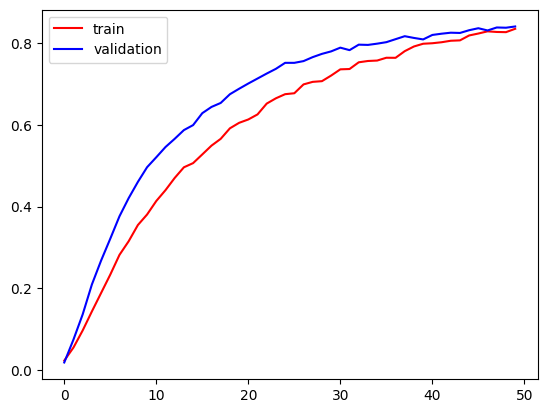

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

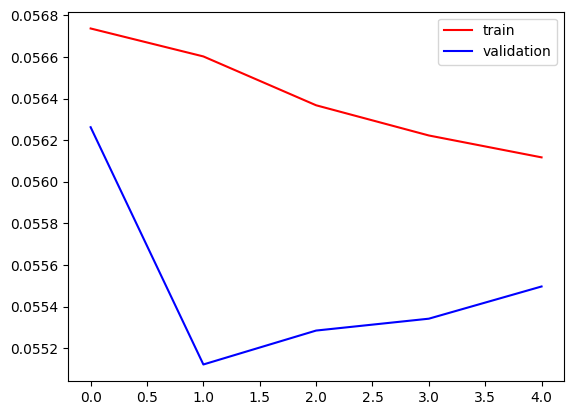

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [25]:
model.save('cnn1.keras')